In [1]:
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Conv2DTranspose, Embedding, Multiply, Activation

from functools import partial

from collections import defaultdict

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import shap

import pandas as pd

class MySequence :
    def __init__(self) :
        self.dummy = 1

keras.utils.Sequence = MySequence

import isolearn.keras as iso

from sequence_logo_helper_protein import plot_protein_logo, letterAt_protein

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += "0"

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)

class NopTransformer(iso.ValueTransformer) :
    
    def __init__(self, n_classes) :
        super(NopTransformer, self).__init__('nop', (n_classes, ))
        
        self.n_classes = n_classes
    
    def transform(self, values) :
        return values
    
    def transform_inplace(self, values, transform) :
        transform[:] = values
    
    def transform_inplace_sparse(self, values, transform_mat, row_index) :
        transform_mat[row_index, :] = np.ravel(values)


Using TensorFlow backend.


In [2]:
#Re-load cached dataframe (shuffled)

dataset_name = "coiled_coil_binders"

experiment = "baker_big_set_5x_negatives"

pair_df = pd.read_csv("pair_df_" + experiment + "_in_shuffled.csv", sep="\t")

print("len(pair_df) = " + str(len(pair_df)))

print(pair_df.head())

#Generate training and test set indexes
valid_set_size = 0.0005
test_set_size = 0.0995

data_index = np.arange(len(pair_df), dtype=np.int)

train_index = data_index[:-int(len(pair_df) * (valid_set_size + test_set_size))]
valid_index = data_index[train_index.shape[0]:-int(len(pair_df) * test_set_size)]
test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


len(pair_df) = 890124
   Unnamed: 0                                       monomer_id_1  \
0           0  redesigned_closed_6_6_9_9middlesbobby_1_4_S_01...   
1           1  redesigned_closed_6_8_9_9middlesbobby_1_4_S_40...   
2           2  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   
3           3  redesigned_closed_5_7_9_9middlesbobby_1_1_S_43...   
4           4  redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...   

                                        monomer_id_2  \
0  redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...   
1  redesigned_closed_5_7_8_10middlesbobby_1_2_S_0...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
3  redesigned_closed_5_6_9_9middlesbobby_1_1_S_25...   
4  redesigned_closed_6_6_8_9middlesbobby_1_5_S_16...   

                                         amino_seq_1  \
0  SEKDLLRLNREILEEIERIQKDLEELLERAERDAEGGLEELEKLVR...   
1  SEKEVMKEQIRLIRENIKAQEEILRLLKELERKGVDKEVEEVIKRI...   
2  DEEEILKILEENLRIQREIDRIHEEQVKALERITRRREDREEIEKL...   
3  STEDI

In [3]:
#Sub-select smaller dataset

n_train_pos = 40000
n_train_neg = 0

n_test_pos = 4000
n_test_neg = 0

orig_n_train = train_index.shape[0]
orig_n_valid = valid_index.shape[0]
orig_n_test = test_index.shape[0]

train_index_pos = np.nonzero((pair_df.iloc[train_index]['interacts'] == 1).values)[0][:n_train_pos]
train_index_neg = np.nonzero((pair_df.iloc[train_index]['interacts'] == 0).values)[0][:n_train_neg]

train_index = np.concatenate([train_index_pos, train_index_neg], axis=0)
np.random.shuffle(train_index)

test_index_pos = np.nonzero((pair_df.iloc[test_index]['interacts'] == 1).values)[0][:n_test_pos] + orig_n_train + orig_n_valid
test_index_neg = np.nonzero((pair_df.iloc[test_index]['interacts'] == 0).values)[0][:n_test_neg] + orig_n_train + orig_n_valid

test_index = np.concatenate([test_index_pos, test_index_neg], axis=0)
np.random.shuffle(test_index)

print('Training set size = ' + str(train_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


Training set size = 40000
Test set size = 4000


In [4]:
#Calculate sequence lengths

pair_df['amino_seq_1_len'] = pair_df['amino_seq_1'].str.len()
pair_df['amino_seq_2_len'] = pair_df['amino_seq_2'].str.len()


In [5]:
pair_df.head()

,Unnamed: 0,monomer_id_1,monomer_id_2,amino_seq_1,amino_seq_2,interacts,amino_seq_1_len,amino_seq_2_len
0,0,redesigned_closed_6_6_9_9middlesbobby_1_4_S_01...,redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...,SEKDLLRLNREILEEIERIQKDLEELLERAERDAEGGLEELEKLVR...,TSEENVERQREHVRTTDEAIKEMEKIIRLLEVVARGEMDRDELRKV...,0.0,70,76
1,1,redesigned_closed_6_8_9_9middlesbobby_1_4_S_40...,redesigned_closed_5_7_8_10middlesbobby_1_2_S_0...,SEKEVMKEQIRLIRENIKAQEEILRLLKELERKGVDKEVEEVIKRI...,STEEVERIVEEVERISRRVVEISRRVVEKIRELIRRMKNERLVELL...,0.0,68,75
2,2,redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...,redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...,DEEEILKILEENLRIQREIDRIHEEQVKALERITRRREDREEIEKL...,RTRELLDEHRKLLEEQERQTKQDEELLREVERRLREELIEMAKDVQ...,0.0,76,68
3,3,redesigned_closed_5_7_9_9middlesbobby_1_1_S_43...,redesigned_closed_5_6_9_9middlesbobby_1_1_S_25...,STEDIARELRKIIRRDKESKKEIKRVHDEQRELAKDAEDSRVVRRL...,GKEEVLEVAKRLLELQEKLQRLHEELQRILDDIVRRKNADDTLVRR...,0.0,76,73
4,4,redesigned_closed_6_6_8_10middlesbobby_1_5_S_2...,redesigned_closed_6_6_8_9middlesbobby_1_5_S_16...,SEKEIIKRLNKLNEDLTRLLETYRRLVEEVERAGALEEELRRRQRE...,SEKEELKRLLEESNKLLELVKEQLRLAEDALRKIAKKARGEVEILE...,0.0,70,77


In [6]:
#Initialize sequence encoder

seq_length = 81

residue_map = {'D': 0, 'E': 1, 'V': 2, 'K': 3, 'R': 4, 'L': 5, 'S': 6, 'T': 7, 'N': 8, 'H': 9, 'A': 10, 'I': 11, 'G': 12, 'P': 13, 'Q': 14, 'Y': 15, 'W': 16, 'M': 17, 'F': 18, '#': 19}

encoder = IdentityEncoder(seq_length, residue_map)


In [7]:
#Construct data generators

class CategoricalRandomizer :
    
    def __init__(self, case_range, case_probs) :
        self.case_range = case_range
        self.case_probs = case_probs
        self.cases = 0
        
    def get_random_sample(self, index=None) :
        if index is None :
            return self.cases
        else :
            return self.cases[index]
    
    def generate_random_sample(self, batch_size=1, data_ids=None) :
        self.cases = np.random.choice(self.case_range, size=batch_size, replace=True, p=self.case_probs)

def get_amino_seq(row, index, flip_randomizer, homodimer_randomizer, max_seq_len=seq_length) :
    
    is_flip = True if flip_randomizer.get_random_sample(index=index) == 1 else False
    is_homodimer = True if homodimer_randomizer.get_random_sample(index=index) == 1 else False
    
    amino_seq_1, amino_seq_2 = row['amino_seq_1'], row['amino_seq_2']
    if is_flip :
        amino_seq_1, amino_seq_2 = row['amino_seq_2'], row['amino_seq_1']
    if is_homodimer and row['interacts'] < 0.5 :
        amino_seq_2 = amino_seq_1
    
    return amino_seq_1, amino_seq_2

flip_randomizer = CategoricalRandomizer(np.arange(2), np.array([0.5, 0.5]))
homodimer_randomizer = CategoricalRandomizer(np.arange(2), np.array([0.95, 0.05]))

batch_size = 32

data_gens = {
    gen_id : iso.DataGenerator(
        idx,
        { 'df' : pair_df },
        batch_size=(idx.shape[0] // batch_size) * batch_size,
        inputs = [
            {
                'id' : 'amino_seq_1',
                'source_type' : 'dataframe',
                'source' : 'df',
                #'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: (get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0] + "#" * seq_length)[:seq_length],
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0],
                'encoder' : IdentityEncoder(seq_length, residue_map),
                'dim' : (1, seq_length, len(residue_map)),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_2',
                'source_type' : 'dataframe',
                'source' : 'df',
                #'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: (get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1] + "#" * seq_length)[:seq_length],
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1],
                'encoder' : IdentityEncoder(seq_length, residue_map),
                'dim' : (1, seq_length, len(residue_map)),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_1_len',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: len(get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[0]),
                'encoder' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            },
            {
                'id' : 'amino_seq_2_len',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index, flip_randomizer=flip_randomizer, homodimer_randomizer=homodimer_randomizer: len(get_amino_seq(row, index, flip_randomizer, homodimer_randomizer)[1]),
                'encoder' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'interacts',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['interacts'],
                'transformer' : NopTransformer(1),
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [flip_randomizer, homodimer_randomizer],
        shuffle = True
    ) for gen_id, idx in [('train', train_index), ('valid', valid_index), ('test', test_index)]
}

#Load data matrices

[x_1_train, x_2_train, l_1_train, l_2_train], [y_train] = data_gens['train'][0]

print("x_1_train.shape = " + str(x_1_train.shape))
print("x_2_train.shape = " + str(x_2_train.shape))

print("l_1_train.shape = " + str(l_1_train.shape))
print("l2_train.shape = " + str(l_2_train.shape))

print("y_train.shape = " + str(y_train.shape))


x_1_train.shape = (40000, 1, 81, 20)
x_2_train.shape = (40000, 1, 81, 20)
l_1_train.shape = (40000, 1)
l2_train.shape = (40000, 1)
y_train.shape = (40000, 1)


In [8]:
#Define sequence templates

sequence_templates = [
    '$' * i + '@' * (seq_length - i)
    for i in range(seq_length+1)
]

sequence_masks = [
    np.array([1 if sequence_templates[i][j] == '$' else 0 for j in range(len(sequence_templates[i]))])
    for i in range(seq_length+1)
]


In [9]:
#Calculate background distributions

pseudo_count = 0.1

x_means = []
x_mean_logits = []
for i in range(seq_length + 1) :
    x_train_len = x_1_train[np.ravel(l_1_train) == i, ...]
    
    if x_train_len.shape[0] > 0 :
        x_mean_len = (np.sum(x_train_len, axis=(0, 1)) + pseudo_count) / (np.sum(x_train_len, axis=(0, 1, 3)).reshape(-1, 1) + 20. * pseudo_count)
        x_mean_logits_len = np.log(x_mean_len)
        
        x_means.append(x_mean_len)
        x_mean_logits.append(x_mean_logits_len)
    else :
        x_means.append(np.zeros((x_1_train.shape[2], x_1_train.shape[3])))
        x_mean_logits.append(np.zeros((x_1_train.shape[2], x_1_train.shape[3])))


In [10]:
#Calculate global background distribution

pseudo_count = 0.1

x_mean = (np.sum(x_1_train, axis=(0, 1)) + pseudo_count) / (np.sum(x_1_train, axis=(0, 1, 3)).reshape(-1, 1) + 20. * pseudo_count)
x_mean_logits = np.log(x_mean_len)


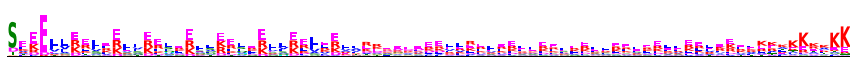

In [11]:
#Visualize background sequence distribution

plot_protein_logo(residue_map, np.copy(x_mean), sequence_template="$" * seq_length, figsize=(12, 1), logo_height=1.0, plot_start=0, plot_end=81)


In [11]:
#Load cached dataframe (shuffled)

dataset_name = "coiled_coil_binders"

experiment = "coiled_coil_binders_alyssa"

data_df = pd.read_csv(experiment + ".csv", sep="\t")

print("len(data_df) = " + str(len(data_df)))

test_df = data_df.copy().reset_index(drop=True)

batch_size = 32
test_df = test_df.iloc[:(len(test_df) // batch_size) * batch_size].copy().reset_index(drop=True)

print("len(test_df) = " + str(len(test_df)))

print(test_df.head())


len(data_df) = 481
len(test_df) = 480
                                        monomer_id_1  \
0  redesigned_closed_5_7_9_9middlesbobby_1_1_S_39...   
1  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_08...   
3  redesigned_closed_5_6_9_10middlesscott_1_1_S_3...   
4  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   

                                        monomer_id_2  \
0  redesigned_closed_5_7_9_9middlesbobby_1_1_S_39...   
1  redesigned_closed_6_6_9_9middlesbobby_1_4_S_07...   
2  redesigned_closed_6_6_9_9middlesbobby_1_4_S_08...   
3  redesigned_closed_5_6_9_10middlesscott_1_1_S_3...   
4  redesigned_closed_6_6_9_10middlesbobby_1_4_S_1...   

                                         amino_seq_1  \
0  DEEELLKLIEDLLKSNKELLDLSKKNLRLLRELVRERNMDDTALRK...   
1  SEKELLELLRELIEDLDRDVKLLRRNVDLHRRVAREGMREELIKKS...   
2  SEEERITEIVKRVEELLRRYEELVKEYKRVLEELRRELREEEQKEL...   
3  SDEEELDEIIKRSEEVMREVEEIDKRVEDIVRKAAKEGASELVKRS...   
4  TVKEL

In [12]:
#Construct test data

batch_size = 32

test_gen = iso.DataGenerator(
    np.arange(len(test_df), dtype=np.int),
    { 'df' : test_df },
    batch_size=(len(test_df) // batch_size) * batch_size,
    inputs = [
        {
            'id' : 'amino_seq_1',
            'source_type' : 'dataframe',
            'source' : 'df',
            #'extractor' : lambda row, index: (row['amino_seq_1'] + "#" * seq_length)[:seq_length],
            'extractor' : lambda row, index: row['amino_seq_1'],
            'encoder' : IdentityEncoder(seq_length, residue_map),
            'dim' : (1, seq_length, len(residue_map)),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_2',
            'source_type' : 'dataframe',
            'source' : 'df',
            #'extractor' : lambda row, index: row['amino_seq_2'] + "#" * seq_length)[:seq_length],
            'extractor' : lambda row, index: row['amino_seq_2'],
            'encoder' : IdentityEncoder(seq_length, residue_map),
            'dim' : (1, seq_length, len(residue_map)),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_1_len',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: len(row['amino_seq_1']),
            'encoder' : lambda t: t,
            'dim' : (1,),
            'sparsify' : False
        },
        {
            'id' : 'amino_seq_2_len',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: len(row['amino_seq_2']),
            'encoder' : lambda t: t,
            'dim' : (1,),
            'sparsify' : False
        }
    ],
    outputs = [
        {
            'id' : 'interacts',
            'source_type' : 'dataframe',
            'source' : 'df',
            'extractor' : lambda row, index: row['interacts'],
            'transformer' : NopTransformer(1),
            'dim' : (1,),
            'sparsify' : False
        }
    ],
    randomizers = [],
    shuffle = False
)

#Load data matrices

[x_1_test, x_2_test, l_1_test, l_2_test], [y_test] = test_gen[0]

print("x_1_test.shape = " + str(x_1_test.shape))
print("x_2_test.shape = " + str(x_2_test.shape))
print("l_1_test.shape = " + str(l_1_test.shape))
print("l_2_test.shape = " + str(l_2_test.shape))

print("y_test.shape = " + str(y_test.shape))


x_1_test.shape = (480, 1, 81, 20)
x_2_test.shape = (480, 1, 81, 20)
l_1_test.shape = (480, 1)
l_2_test.shape = (480, 1)
y_test.shape = (480, 1)


In [13]:

def get_shared_model() :
    
    gru_1 = Bidirectional(GRU(64, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0, unroll=False, use_bias=True, reset_after=True, return_sequences=False), merge_mode='concat')
    
    drop_1 = Dropout(0.25)

    def shared_model(inp) :

        gru_1_out = gru_1(inp)
        
        drop_1_out = drop_1(gru_1_out)

        return drop_1_out
    
    return shared_model

shared_model = get_shared_model()

#Inputs
res_both = Input(shape=(1, seq_length * 2, 19 + 1))

[res_1, res_2] = Lambda(lambda x: [x[:, 0, :seq_length, :], x[:, 0, seq_length:, :]])(res_both)

#Outputs
true_interacts = Input(shape=(1,))

#Interaction model definition
dense_out_1 = shared_model(res_1)
dense_out_2 = shared_model(res_2)

layer_dense_pair_1 = Dense(128, activation='relu')
dense_out_pair = layer_dense_pair_1(Concatenate(axis=-1)([dense_out_1, dense_out_2]))

pred_interacts = Dense(1, activation='sigmoid', kernel_initializer='zeros')(dense_out_pair)

predictor = Model(
    inputs=[
        res_both
    ],
    outputs=pred_interacts
)

predictor.load_weights('saved_models/ppi_rnn_baker_big_set_5x_negatives_classifier_symmetric_drop_25_5x_negatives_balanced_partitioned_data_epoch_10.h5', by_name=False)
predictor.trainable = False

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.









In [14]:
x_train = np.concatenate([
    x_1_train,
    x_2_train
], axis=2)

x_test = np.concatenate([
    x_1_test,
    x_2_test
], axis=2)

In [15]:
#Select background set of images

background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]


In [17]:
#Execute DeepSHAP attribution method

e = shap.DeepExplainer(predictor, background)
#e = shap.DeepExplainer((predictor.layers[0].input, predictor.layers[-1].output), background)

shap_values = e.shap_values(x_test)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:

importance_scores_test = np.zeros(shap_values[0].shape)

importance_scores_test[:, :, :, :] = shap_values[0][:, :, :, :]

importance_scores_1_test, importance_scores_2_test = importance_scores_test[:, :, :seq_length, :], importance_scores_test[:, :, seq_length:, :]

importance_scores_1_test_signed = np.copy(importance_scores_1_test * x_1_test)
importance_scores_1_test = np.abs(importance_scores_1_test * x_1_test)

importance_scores_2_test_signed = np.copy(importance_scores_2_test * x_2_test)
importance_scores_2_test = np.abs(importance_scores_2_test * x_2_test)



In [16]:
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_protein_logo(residue_map, pwm, sequence_template=None, figsize=(12, 3), logo_height=1.0, plot_start=0, plot_end=164) :

    inv_residue_map = {
        i : sp for sp, i in residue_map.items()
    }

    #Slice according to seq trim index
    pwm = pwm[plot_start: plot_end, :]
    sequence_template = sequence_template[plot_start: plot_end]

    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(np.clip(pwm[pwm > 0], 1e-6, 1. - 1e-6))
    entropy = np.sum(entropy, axis=1)
    conservation = np.log2(len(residue_map)) - entropy#2 - entropy

    fig = plt.figure(figsize=figsize)

    ax = plt.gca()
    
    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, len(residue_map)) :
            i = sort_index[ii]
            
            if pwm[j, i] > 0 :
                nt_prob = pwm[j, i] * conservation[j]

                nt = inv_residue_map[i]

                color = None
                if sequence_template[j] != '$' :
                    color = 'black'

                if ii == 0 :
                    letterAt_protein(nt, j + 0.5, height_base, nt_prob * logo_height, ax, color=color)
                else :
                    prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                    letterAt_protein(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax, color=color)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, np.log2(len(residue_map))))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    plt.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)


    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    plt.show()

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96, save_figs=False, fig_name=None) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        letterAt_protein(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=None)

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)
    
    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()


Test sequence 0:


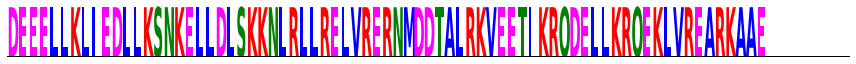

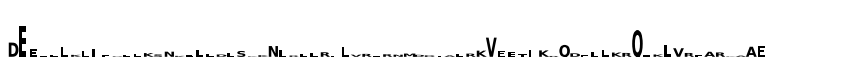

Test sequence 1:


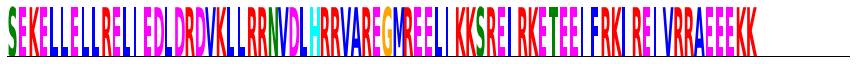

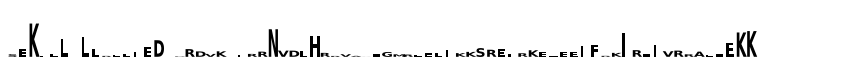

Test sequence 2:


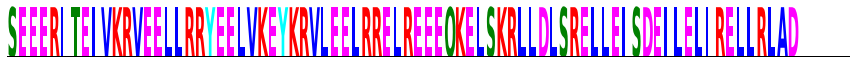

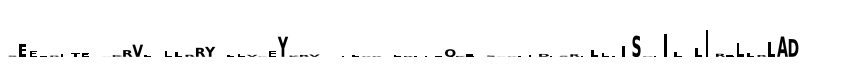

Test sequence 3:


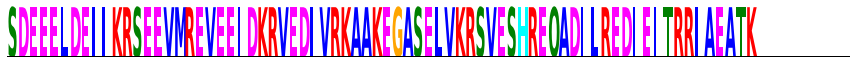

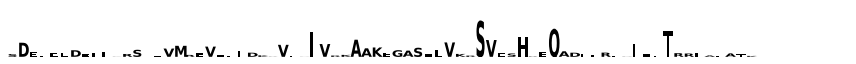

Test sequence 4:


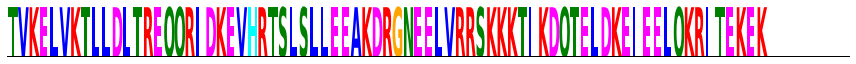

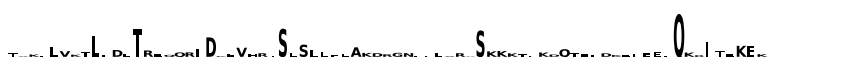

Test sequence 0:


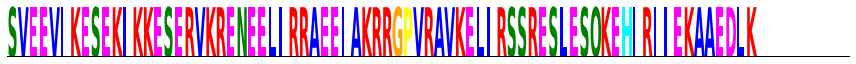

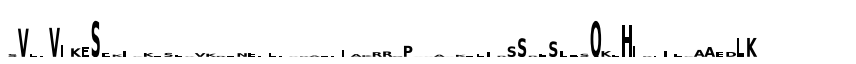

Test sequence 1:


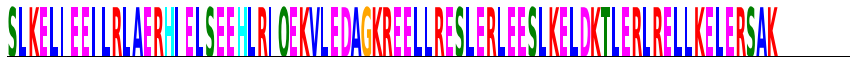

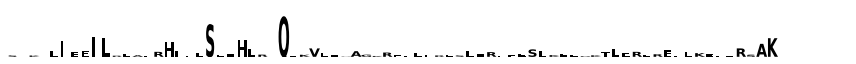

Test sequence 2:


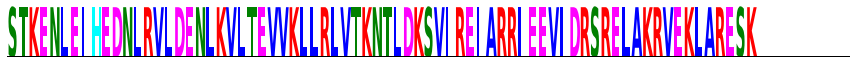

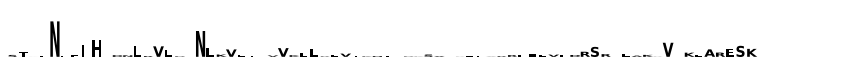

Test sequence 3:


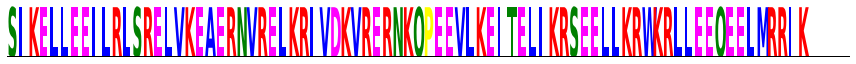

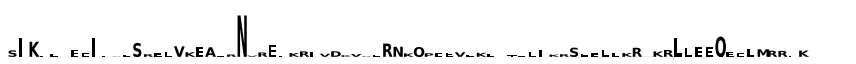

Test sequence 4:


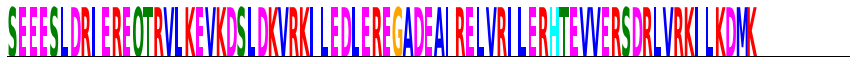

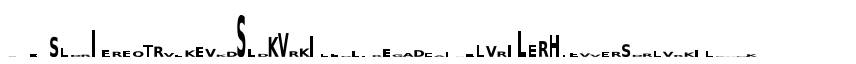

In [24]:
#Visualize importance for binder 1

for plot_i in range(0, 5) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = sequence_templates[l_1_test[plot_i, 0]]

    plot_protein_logo(residue_map, x_1_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(importance_scores_1_test[plot_i, 0, :, :].T, encoder.decode(x_1_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81)

#Visualize importance for binder 2

for plot_i in range(0, 5) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = sequence_templates[l_2_test[plot_i, 0]]

    plot_protein_logo(residue_map, x_2_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(importance_scores_2_test[plot_i, 0, :, :].T, encoder.decode(x_2_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81)


In [25]:
#Save predicted importance scores

model_name = "deepshap_" + dataset_name + "_zeropad"

np.save(model_name + "_importance_scores_1_test", importance_scores_1_test)
np.save(model_name + "_importance_scores_1_test_signed", importance_scores_1_test_signed)


In [26]:
#Save predicted importance scores

model_name = "deepshap_" + dataset_name + "_zeropad"

np.save(model_name + "_importance_scores_2_test", importance_scores_2_test)
np.save(model_name + "_importance_scores_2_test_signed", importance_scores_2_test_signed)


In [17]:
#Binder DHD_154

#seq_1 = ("TAEELLEVHKKSDRVTKEHLRVSEEILKVVEVLTRGEVSSEVLKRVLRKLEELTDKLRRVTEEQRRVVEKLN" + "#" * seq_length)[:81]
#seq_2 = ("DLEDLLRRLRRLVDEQRRLVEELERVSRRLEKAVRDNEDERELARLSREHSDIQDKHDKLAREILEVLKRLLERTE" + "#" * seq_length)[:81]
seq_1 = "TAEELLEVHKKSDRVTKEHLRVSEEILKVVEVLTRGEVSSEVLKRVLRKLEELTDKLRRVTEEQRRVVEKLN"[:81]
seq_2 = "DLEDLLRRLRRLVDEQRRLVEELERVSRRLEKAVRDNEDERELARLSREHSDIQDKHDKLAREILEVLKRLLERTE"[:81]

print("Seq 1 = " + seq_1)
print("Seq 2 = " + seq_2)

encoder = IdentityEncoder(81, residue_map)

test_onehot_1 = np.tile(np.expand_dims(np.expand_dims(encoder(seq_1), axis=0), axis=0), (batch_size, 1, 1, 1))
test_onehot_2 = np.tile(np.expand_dims(np.expand_dims(encoder(seq_2), axis=0), axis=0), (batch_size, 1, 1, 1))

test_len_1 = np.tile(np.array([[len(seq_1)]]), (batch_size, 1))
test_len_2 = np.tile(np.array([[len(seq_2)]]), (batch_size, 1))


Seq 1 = TAEELLEVHKKSDRVTKEHLRVSEEILKVVEVLTRGEVSSEVLKRVLRKLEELTDKLRRVTEEQRRVVEKLN
Seq 2 = DLEDLLRRLRRLVDEQRRLVEELERVSRRLEKAVRDNEDERELARLSREHSDIQDKHDKLAREILEVLKRLLERTE


In [18]:

x_1_test = test_onehot_1[:1]
x_2_test = test_onehot_2[:1]
l_1_test = test_len_1[:1]
l_2_test = test_len_2[:1]

x_test = np.concatenate([
    x_1_test,
    x_2_test
], axis=2)


In [19]:
#Execute DeepSHAP attribution method

e = shap.DeepExplainer(predictor, background)
#e = shap.DeepExplainer((predictor.layers[0].input, predictor.layers[-1].output), background)

shap_values = e.shap_values(x_test)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:

importance_scores_test = np.zeros(shap_values[0].shape)

importance_scores_test[:, :, :, :] = shap_values[0][:, :, :, :]

importance_scores_1_test, importance_scores_2_test = importance_scores_test[:, :, :seq_length, :], importance_scores_test[:, :, seq_length:, :]

importance_scores_1_test_signed = np.copy(importance_scores_1_test * x_1_test)
importance_scores_1_test = np.abs(importance_scores_1_test * x_1_test)

importance_scores_2_test_signed = np.copy(importance_scores_2_test * x_2_test)
importance_scores_2_test = np.abs(importance_scores_2_test * x_2_test)


Test sequence 0:


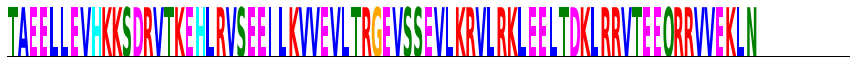

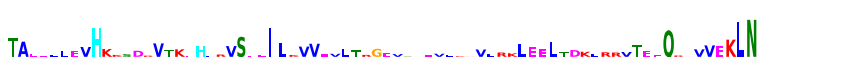

Test sequence 0:


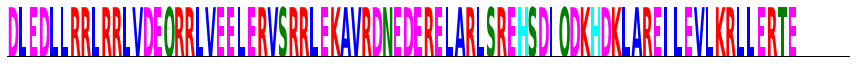

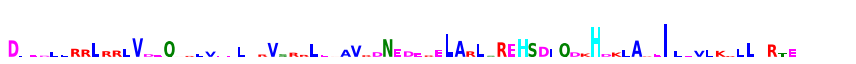

In [21]:

save_figs = True

model_name = "deepshap_" + dataset_name + "_zeropad"

pair_name = "DHD_154"

#Visualize importance for binder 1

for plot_i in range(0, 1) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = sequence_templates[l_1_test[plot_i, 0]]

    plot_protein_logo(residue_map, x_1_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(importance_scores_1_test[plot_i, 0, :, :].T, encoder.decode(x_1_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_scores_" + pair_name + "_binder_1")

#Visualize importance for binder 2

for plot_i in range(0, 1) :

    print("Test sequence " + str(plot_i) + ":")
    
    sequence_template = sequence_templates[l_2_test[plot_i, 0]]

    plot_protein_logo(residue_map, x_2_test[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(12, 1), plot_start=0, plot_end=81)
    plot_importance_scores(importance_scores_2_test[plot_i, 0, :, :].T, encoder.decode(x_2_test[plot_i, 0, :, :]), figsize=(12, 1), score_clip=None, sequence_template=sequence_template, plot_start=0, plot_end=81, save_figs=save_figs, fig_name=model_name + "_scores_" + pair_name + "_binder_2")
